In [1]:
import numpy as np
import keras
import random
from keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
import random
import cv2
from scipy import ndimage
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras.backend as K

In [2]:
path = "D:/downloads/train/"
path_seis = os.path.join(path,'seis')
path_fault = os.path.join(path,'fault')
validation_path = "D:/downloads/validation/"
validation_seis = os.path.join(validation_path,'seis')
validation_fault = os.path.join(validation_path,'fault')

In [3]:
def get_data(seis_path, fault_path):
    seis_names = os.listdir(seis_path)
    fault_names = os.listdir(fault_path)
    X = []
    Y = []
    for i in range(len(seis_names)):
        seis_cube = np.fromfile(os.path.join(seis_path, seis_names[i]),dtype=np.single)
        faults = np.fromfile(os.path.join(fault_path, fault_names[i]),dtype=np.single)
        dim = (128,128,128)
        seis_cube = np.reshape(seis_cube, dim)
        fault = np.reshape(faults, dim)
        seis_m = np.mean(seis_cube)
        seis_sigma = np.std(seis_cube)
        seis_cube_norm = (seis_cube-seis_m)/seis_sigma
        x = np.reshape(seis_cube_norm,(1,128,128,128,1))
        y =  np.reshape(fault,(1,128,128,128,1))

        for k in range(128):
            X.append(np.transpose(x[0,k,:,:,0]))
            X.append(np.transpose(x[0,:,k,:,0]))
            Y.append(np.transpose(y[0,k,:,:,0]))
            Y.append(np.transpose(y[0,:,k,:,0]))
    X = np.array(X)
    Y = np.array(Y)
    X = X/255.0
    return X,Y
    

In [4]:
dataset, target = get_data(path_seis, path_fault)
print(dataset.shape)
validation_x, validation_y = get_data(validation_seis, validation_fault)
print(validation_x.shape)

(51200, 128, 128)
(5120, 128, 128)


In [5]:
x_train, x_test, y_train, y_test = train_test_split(dataset, target, random_state=4)
print(x_train.shape, x_test.shape)

(38400, 128, 128) (12800, 128, 128)


# Data visualisation

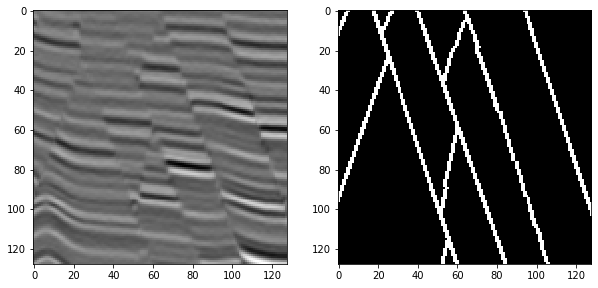

In [6]:
seis_cube = x_train[10]
faults = y_train[10]
fig = plt.figure(figsize=(10,10))
k1 = 5
plt.subplot(1, 2, 1)
imgplot1 = plt.imshow(seis_cube,interpolation='nearest',aspect=1,cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
imgplot2 = plt.imshow(faults,interpolation='nearest',aspect=1,cmap=plt.cm.gray)

In [7]:
def rotation(pair,angle):
    pair[0] = ndimage.rotate(pair[0], angle) 
    pair[1] = ndimage.rotate(pair[1], angle)
    pair[0] = cv2.resize(pair[0],(128,128))
    pair[1] = cv2.resize(pair[1],(128,128))
    return pair

def blur(pair):
    kernel = (random.randint(1,10), random.randint(1,5))
    pair[0] = cv2.blur(pair[0], kernel)
    pair[1] = cv2.blur(pair[1], kernel)
    pair[0] = cv2.resize(pair[0],(128,128))
    pair[1] = cv2.resize(pair[1],(128,128))
    return pair

def flip(pair):
    flip = random.randint(-1,1)
    pair[0] = cv2.flip(pair[0], flip)
    pair[1] = cv2.flip(pair[1], flip)
    pair[0] = cv2.resize(pair[0],(128,128))
    pair[1] = cv2.resize(pair[1],(128,128))
    return pair
    
def augmentations(pair, type_of_augmentation):
    cases = {
        '1': lambda pair: rotation(pair, random.choice([90, 180, 270, 360])),
        '2': lambda pair: blur(pair),
        '3': lambda pair: flip(pair)
    }
    result = cases[str(type_of_augmentation)]
    return result(pair)



In [8]:
def augmentation(quantity, X, Y):
    pairs = [[X[i], Y[i]] for i in range(quantity)]
    x_augmented = pairs
    for i, pair in enumerate(pairs):
        x_augmented[i] = augmentations(pair, random.randint(1,3))
    x_augmented = np.array(x_augmented)
    return x_augmented

In [9]:
x_augmented = augmentation(250, x_train, y_train)
x_train = np.append(x_train, x_augmented[:,0],axis=0)
y_train = np.append(y_train, x_augmented[:,1],axis=0)

In [10]:
def cross_entropy_balanced(y_true, y_pred):
    # Note: tf.nn.sigmoid_cross_entropy_with_logits expects y_pred is logits,
    # Keras expects probabilities.
    # transform y_pred back to logits
    y_true = tf.cast(y_true, tf.float32)
    count_neg = tf.reduce_sum(1. - y_true)
    count_pos = tf.reduce_sum(y_true)
#     beta = count_neg / (128*128)
    beta = 0.1;#count_neg / (count_neg + count_pos)
    pos_weight = beta/(1-beta) #1 - tf.reduce_mean(y_true)
    cost = tf.nn.weighted_cross_entropy_with_logits(y_pred, y_true, pos_weight=pos_weight)
    return tf.reduce_mean(cost)

def _to_tensor(x, dtype):
    """Convert the input `x` to a tensor of type `dtype`.
    # Arguments
    x: An object to be converted (numpy array, list, tensors).
    dtype: The destination type.
    # Returns
    A tensor.
    """
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x

In [11]:
def unet(input_size = (None,None,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(32, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(64, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    pool3 = Dropout(0.5)(pool3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2,2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2,2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(32, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(32, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2,2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(16, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(16, 3, activation='relu', padding='same')(conv7)
    
    conv7 = Dropout(0.5)(conv7)
    
    conv8 = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[conv8])
    model.summary()
    return model

In [15]:
model = unet(input_size=(None, None, 1))
model.compile(optimizer=Adam(lr=1e-3), loss= 'binary_crossentropy',
              #cross_entropy_balanced, 
            metrics=['accuracy'])
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, None, None, 1 160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, None, None, 1 2320        conv2d_30[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, None, None, 1 0           conv2d_31[0][0]                  
_______________________________________________________________________________________

# Model fit

In [16]:
log_dir = "logs/2dseg/" + "balanced"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(x = x_train,y=y_train, epochs=5, batch_size=64, validation_data = (validation_x, validation_y),
        callbacks=[tensorboard_callback] )
model.save_weights('weights_balanced.h5')

Epoch 1/5
604/604 [==============================] - 2950s 5s/step - loss: 0.2816 - accuracy: 0.9275 - val_loss: 0.1661 - val_accuracy: 0.9424
Epoch 2/5
604/604 [==============================] - 2951s 5s/step - loss: 0.1564 - accuracy: 0.9491 - val_loss: 0.1466 - val_accuracy: 0.9527
Epoch 3/5
604/604 [==============================] - 3099s 5s/step - loss: 0.1346 - accuracy: 0.9543 - val_loss: 0.1269 - val_accuracy: 0.9563
Epoch 4/5
604/604 [==============================] - 3059s 5s/step - loss: 0.1244 - accuracy: 0.9563 - val_loss: 0.1222 - val_accuracy: 0.9573
Epoch 5/5
604/604 [==============================] - 7570s 13s/step - loss: 0.1176 - accuracy: 0.9573 - val_loss: 0.1214 - val_accuracy: 0.9582


In [17]:
print(x_test.shape)
x_test[0].reshape(128,128,1)
y = model.predict(x_test)
print(y[0].shape)

(12800, 128, 128)
(128, 128, 1)


0.6965365585486532


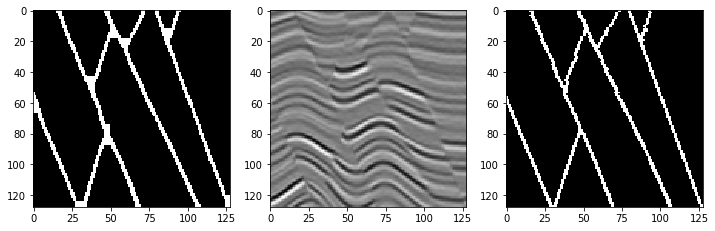

In [18]:
#mask = y[900].reshape(128,128)
k = 900
mask = y[k]
kernel = np.ones((5,5), np.uint8)
mask = np.around((mask) * 255).astype(np.uint8)
nothing, mask = cv2.threshold(mask, 110, 255, cv2.THRESH_BINARY)
mask = cv2.dilate(mask, np.ones((5,5), np.uint8), iterations = 1)
mask = cv2.erode(mask, kernel, iterations = 1)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
imgplot1 = plt.imshow(mask,interpolation='nearest',aspect=1,cmap=plt.cm.gray)
plt.subplot(1,3,2)
imgplot2 = plt.imshow(x_test[k],interpolation='nearest',aspect=1,cmap=plt.cm.gray)
mask_test = y_test[k]#.reshape(128,128)
plt.subplot(1,3,3)
imgplot3 = plt.imshow(mask_test,interpolation='nearest',aspect=1,cmap=plt.cm.gray)
intersection = np.logical_and(mask_test, mask)
union = np.logical_or(mask_test, mask)
iou_score = np.sum(intersection) / np.sum(union)
print(iou_score)

In [19]:
iou = []
for i in range(y.shape[0]):
    target = y_test[i]
    prediction = y[i]
    prediction = np.around((prediction) * 255).astype(np.uint8)
    x, prediction = cv2.threshold(prediction, 110, 255, cv2.THRESH_BINARY)
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    iou.append(iou_score)
    print(iou_score)

0.4529012810851545
0.5943396226415094
0.2991329479768786
0.732484076433121
0.34325396825396826
0.2814526588845655
0.6738078783690394
0.4676903390914907
0.6463595839524517
0.3564294631710362
0.6284114765570329
0.16940581542351454
0.5013642564802183
0.6480938416422287
0.4466230936819172
0.7155664221678891
0.7370478983382209
0.7346683354192741
0.5702970297029702
0.5155058464667006
0.7918502202643172
0.6219409282700422
0.656437125748503
0.5480059084194978
0.46017699115044247
0.1601289629231596
0.41706484641638225
0.5785354946897708
0.6321243523316062
0.6672369546621043
0.5286415711947627
0.5990074441687345
0.6605981794538361
0.7090216010165185
0.6601371204701273
0.5270555165144062
0.5813820673900628
0.6882893226176808
0.7063243581715717
0.48559670781893005
0.5821305841924399
0.5966555183946488
0.5931919642857143
0.7000871839581517
0.5246478873239436
0.5275974025974026
0.7195696032279758
0.71024512884978
0.7318718381112985
0.7589058524173028
0.7098298676748582
0.5667655786350149
0.505003849

C:\Users\Sizov\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


0.6155572176514585
0.6189917936694022
0.7251356238698011
0.6065482796892342
0.5747384155455905
0.7778855480116392
0.6066666666666667
0.4171907756813417
0.5972696245733788
0.6775836972343523
0.4704761904761905
0.7311935807422267
0.7306477093206951
0.30128205128205127
0.6492753623188405
0.4738955823293173
0.7023661270236613
0.589231699939504
nan
0.7115183246073299
0.4472712351251539
0.5919117647058824
0.7961399276236429
0.674591381872214
0.7026813880126183
0.49535315985130113
0.5443037974683544
nan
0.413075780089153
0.4087403598971722
0.6865168539325842
0.5263513513513514
0.5597014925373134
0.7535410764872521
0.7013221153846154
0.6084683742812337
0.5713483146067416
0.5223509933774835
0.6641477749790092
0.4722222222222222
0.5432733504712939
0.3417910447761194
0.771509167842031
0.45652173913043476
0.6757153338224505
0.7135678391959799
0.7099358974358975
0.6107977437550363
0.6321905868680999
0.6036496350364964
0.6933867735470942
0.5647899910634495
0.7635467980295566
0.6558741905642923
0.668

0.5924339757316203
0.5679287305122495
0.6625322997416021
0.2127659574468085
0.5269878119558908
0.5437566702241196
0.08016147635524798
0.6155419222903885
0.6986394557823129
0.6919104991394148
0.6912637828668363
0.5432953983176645
0.48954372623574144
0.5979843225083986
0.6602409638554216
0.46798365122615804
0.5651302605210421
0.5810955961331902
0.3292349726775956
0.5329719963866305
0.46395563770794823
0.378698224852071
0.5417867435158501
0.558125
0.6389337641357028
0.6093640810621943
0.6298527443105756
0.5720221606648199
0.6201298701298701
0.5559105431309904
0.6647314949201741
0.7003853564547207
0.5892193308550185
0.5266617969320672
0.6725043782837128
0.6678614097968937
0.7475447718082033
0.6882793017456359
0.7544910179640718
0.5663283164158208
0.45714285714285713
0.41337630942788073
0.6252319109461967
0.7348119575699132
0.7112582781456953
0.4557774607703281
0.4290407358738502
0.5738019169329074
0.7862595419847328
0.4450022820629849
0.6768853464132434
0.6222222222222222
0.333065164923572

0.6784287616511319
0.6084021005251313
0.645224171539961
0.8
0.5655502392344498
0.7014057198254968
0.6810551558752997
0.5988243938280676
0.5971451229183188
0.19417077175697867
0.6883963494132985
0.6984872196139802
0.5224358974358975
0.6533795493934142
0.6906211936662606
0.6063694267515923
0.06382978723404255
0.6741363211951448
0.7403174603174603
0.6952830188679245
0.6631234668847097
0.7055800293685757
0.7120921305182342
0.6355841371918542
0.594547053649956
0.5905077262693157
0.48111510791366907
0.7232
0.31094527363184077
0.590625
0.6275555555555555
0.5844155844155844
0.4504106127605812
0.6207513416815742
0.498468606431853
0.3378561736770692
0.6396120469627361
0.6480793060718711
0.5044008124576845
0.3879239040529363
0.6096361848574238
0.6829052258635961
0.5712109672505712
0.30592592592592593
0.6133333333333333
0.675645342312009
0.6293045239702904
0.6020599250936329
0.7523167649536647
0.6214421252371917
0.24918743228602383
0.5455284552845528
0.758893280632411
0.42901234567901236
0.4916170

0.6207559256886611
0.4591194968553459
0.12712623097582812
0.5816640986132512
0.6541666666666667
0.6375404530744336
0.43932346723044396
0.6777003484320557
0.47339449541284406
0.5158371040723982
0.585812356979405
0.47434885556432516
0.7758620689655172
0.5846432889963724
0.550808793031937
0.1806136680613668
0.3572009764035802
0.5443107221006565
0.7539170506912443
0.4427536231884058
0.6689053055742109
0.6705813270698767
0.7467972871137905
0.7744186046511627
0.469060773480663
0.4766917293233083
0.5850746268656717
0.5234131113423517
0.580607476635514
0.5940130963517306
0.6769596199524941
0.7277978339350181
0.7617702448210922
0.6153119092627599
0.7263681592039801
0.5990813648293963
0.47557603686635946
0.4636363636363636
0.5462412114656571
0.6811320754716981
0.5989949748743718
0.5544192841490139
0.7036423841059603
0.4163380281690141
0.7201298701298702
0.6251612903225806
0.2949586155003762
0.12883435582822086
0.47973531844499584
0.5065616797900262
0.6694063926940639
0.5166279969064191
0.6358658

0.5145067698259188
0.5925093632958801
0.5720443349753694
0.7285223367697594
0.7485207100591716
0.22155328115593018
0.6550777676120768
0.5233892321270962
0.3512396694214876
0.20254169976171565
0.5059880239520959
0.6787383177570093
0.4278523489932886
0.45161290322580644
0.5670103092783505
0.448292220113852
0.4246031746031746
0.5694849368318756
0.6056338028169014
0.3320522674865488
0.35006605019815057
0.4484472049689441
0.2624053826745164
0.5194472876151485
0.739972337482711
0.523422860712055
0.5880503144654088
0.7016949152542373
0.6103169670602859
0.6207090602138435
0.5298651252408478
0.6199478487614081
0.6743215031315241
0.6741573033707865
0.4190938511326861
0.5623081645181093
0.7871740662438337
0.8060453400503779
0.43308080808080807
0.33694181326116374
0.7486631016042781
0.5889967637540453
0.6994359387590653
0.6261879619852164
0.5576070901033974
0.49894736842105264
0.554177005789909
0.6446644664466447
0.620327868852459
0.5697151424287856
0.4789915966386555
0.2315340909090909
0.63273809

0.4421864050455501
0.562407132243685
0.5802872062663186
0.7443249701314217
0.46737357259380097
0.6846100759144237
0.5413086582947786
0.7261287934863064
0.6354992076069731
0.6911045943304008
0.6650446066504461
0.38746438746438744
0.5586380832282472
0.2506527415143603
0.5960099750623441
0.6209850107066381
0.645381984036488
0.6203125
0.6529477196885428
0.5970149253731343
0.45572450805008946
0.7021414665801428
0.5827900912646675
0.5866666666666667
0.7158395649218219
0.6461619348054679
0.5138121546961326
0.6666666666666666
0.5796637309847879
0.5104732350659426
0.7077625570776256
0.16563658838071693
0.6202090592334495
0.5894800483675937
0.32445690259285215
0.3452502553626149
0.7357357357357357
0.6156496062992126
0.5782608695652174
0.7967581047381546
0.7566909975669099
0.6423043852106621
0.7149178255372945
0.6403326403326404
0.5841363973313566
0.6953405017921147
0.6536558548653106
0.6492329149232915
0.6564171122994652
0.6031187122736419
0.5573294629898403
0.7276867030965392
0.7443037974683544

0.7109962406015038
0.4319189360354655
0.20715942989724892
0.6506410256410257
0.4423728813559322
0.8191056910569106
0.5769522365428355
0.1480637813211845
0.0
nan
0.6282051282051282
0.670906200317965
0.6313333333333333
0.7235087719298245
0.8042744656917885
0.6905871388630009
0.6697513013302487
0.7251542152159013
0.6684523809523809
0.6576862123613312
0.8027079303675049
0.6299585553582001
0.5652797704447633
0.4050632911392405
0.7140319715808171
0.5695581014729951
0.6335578002244668
0.5583524027459954
0.4109772423025435
0.47651006711409394
0.5356265356265356
0.5447498238195913
0.5164113785557987
0.7474489795918368
0.5976408912188729
0.3964941569282137
0.31759656652360513
0.4319009468317553
0.6485215053763441
0.5761772853185596
0.7161172161172161
0.7597684515195369
0.5155061439438268
0.6833229231730169
0.5749785775492716
0.7469362745098039
0.5671328671328671
0.4358186010760953
0.6423889293517844
0.5302713987473904
0.6464088397790055
0.764449968924798
0.4837364470391993
0.5713058419243986
0.6

0.4976923076923077
0.6913756236635781
0.14026517794836008
0.33473095737246683
0.4377880184331797
0.6072530864197531
0.7063829787234043
0.3383199079401611
0.44328703703703703
0.660956459671663
0.24051948051948052
0.4832379394930499
0.4177545691906005
0.5794813979706878
0.7044534412955465
0.5089153046062407
0.4321236559139785
0.45153473344103395
0.7703412073490814
0.3863439930855661
0.38841405508072174
0.8028962188254224
0.7468239564428312
0.3983122362869198
0.6395864106351551
0.4819129368485592
0.5656652360515021
0.507295719844358
0.5626043405676127
0.24924012158054712
0.666043030869972
0.46680080482897385
0.6810414971521562
0.48226097414311486
0.6718547341115434
0.3869346733668342
nan
0.728515625
0.359375
0.5634920634920635
0.6712611991729841
0.6264462809917355
0.7570332480818415
0.5267633816908455
0.6699104710003893
0.5563209076175041
0.6021660649819495
0.6405529953917051
0.5801937567276642
0.34996801023672425
0.8015783540022547
0.4900662251655629
0.5962848297213622
0.4021532615579480

0.7828655834564254
0.6153846153846154
0.2874629080118694
0.6897608828939301
0.6988188976377953
0.6402814423922604
0.6810683424980362
0.0
0.6558966074313409
0.0
0.5108601216333623
0.5717717717717717
0.6560283687943262
0.5262096774193549
0.7284448025785657
0.7068493150684931
0.5671732522796352
0.6152482269503546
0.6114882506527415
0.4485541358439812
0.6086532205595315
0.5313267813267813
0.6222222222222222
0.47525722684958355
0.6923076923076923
0.23148148148148148
0.5195833333333333
0.5272459499263623
0.7121212121212122
0.7198606271777004
0.5027548209366391
0.6697429136453527
0.6275229357798165
0.32228218966846567
0.33087330873308735
0.5783699059561128
0.6671459381739756
0.7102161100196464
0.6634615384615384
0.5748560460652591
0.5485342019543974
0.3776223776223776
0.5491846396633351
0.7801013941698353
0.6949404761904762
0.5849673202614379
0.6224689745264533
0.5538140020898642
0.7094017094017094
0.3169722057953873
0.2727272727272727
0.49346793349168644
0.6936642717178315
0.7264600715137068

0.6413373860182371
0.6805465191932336
0.4109090909090909
0.5548387096774193
0.7072340425531914
0.24648985959438377
0.34996220710506426
0.6936685288640596
0.7736916548797736
0.6475930971843779
0.432503970354685
0.6830188679245283
0.5325034578146611
0.4794383149448345
0.4863013698630137
0.7040169133192389
0.44948849104859334
0.5798525798525799
0.6978021978021978
0.23809523809523808
0.5533869115958668
0.75
0.4287856071964018
0.4518156424581006
0.6766205389657683
0.6377245508982036
0.6698564593301436
0.7006369426751592
0.5013262599469496
0.24311926605504589
0.5637030247479377
0.3570175438596491
0.6455399061032864
0.6076099881093936
0.6148451198129748
0.5922406967537609
0.7734806629834254
0.7214996174445295
0.07363013698630137
0.5892002734107997
0.5618345618345618
0.4514370664023786
0.545974025974026
0.4438964241676942
0.45246690734055356
0.6753434562545192
0.5726341169379144
nan
0.5378698224852071
0.6887470071827614
0.726775956284153
0.6843872411863459
0.6545123062898814
0.52303961196443
0

0.7305101058710298
0.6470194239785666
nan
0.6747875354107649
0.44584081388390184
0.6604683195592287
0.6272257323377369
0.7102342786683107
0.37813884785819796
0.49581939799331104
0.13924050632911392
0.4307116104868914
0.6066547831253714
0.6234509056244042
0.5382262996941896
0.44905008635578586
0.3850393700787402
0.5388760585065435
0.7043147208121827
0.12034383954154727
0.5947136563876652
0.7274881516587678
0.437
0.5104225352112676
0.5300240192153723
0.6823425022182786
0.18915929203539822
0.49174917491749176
0.5233502538071066
0.35402906208718626
0.5361010830324909
0.0
0.7201581027667984
0.44732441471571904
0.6677018633540373
0.42847364818617384
0.3407270486752927
0.64453125
0.6201923076923077
0.7299349240780911
0.13805970149253732
0.5360896986685354
0.6080627099664053
0.6327974276527332
0.5262798634812287
0.7034482758620689
0.14755766621438263
0.704995287464656
0.5360094451003542
0.3588516746411483
0.5491462851868943
0.7045735475896168
0.7129742962056304
0.5059565522074282
0.37202553685

0.7053344623200677
0.6512327119663259
0.631875
0.32646048109965636
0.5125094768764216
0.6272670419011882
0.3342503438789546
0.6265060240963856
0.09792843691148775
0.4976825028968714
0.5157342657342657
0.7583834909716252
0.5792838874680307
0.454691259021652
0.7207903780068728
0.5174654752233956
0.6037735849056604
0.4343065693430657
0.5516693163751988
0.6453353893600616
0.7362093352192363
0.5114235500878734
0.6787365177195686
0.6044039483675019
0.5442374854481956
0.6413124533929903
0.5709969788519638
0.47909407665505227
0.4097222222222222
0.19880546075085323
0.48996350364963503
0.6884955752212389
0.46258503401360546
0.5286153846153846
0.3546712802768166
0.4327217125382263
0.5852864583333334
0.5029585798816568
0.6071076011846002
0.7016029593094945
0.6832412523020258
0.33832976445396146
0.6783767413688674
0.45744029393753827
0.432280701754386
0.5589519650655022
0.5825242718446602
0.5786593707250342
0.5572305974316024
0.007223942208462332
0.5908440629470673
0.579203899268887
0.7016885553470

0.5351976856316297
0.6535211267605634
0.5028462998102466
0.743549648162627
0.7794253938832252
0.5564042303172738
0.3581081081081081
0.6778774289985052
0.6386986301369864
0.606675392670157
0.7120567375886525
0.7058823529411765
0.4468589490320032
0.38267644362969755
0.48671328671328673
0.5084835630965006
0.4317617866004963
nan
0.5401459854014599
0.47518126045733405
0.5680317040951123
0.8141233766233766
0.417610710607621
0.5260631001371742
0.6479076479076479
0.38023715415019765
0.6661264181523501
0.7877325982081324
0.6709704289879217
0.6572040707016604
0.740418118466899
0.6067205973864344
0.5408450704225352
nan
0.8026214340786431
0.6087990487514863
0.6202277294038848
0.6478260869565218
0.6401869158878505
0.5291828793774319
0.7760683760683761
0.6356545961002785
0.37395957193816887
0.6620241411327762
0.49656974844821955
0.5633720930232559
0.7964470762398224
0.5410176531671859
0.5966312056737588
0.48695652173913045
nan
0.624031007751938
0.08
0.5973223480947477
0.6995810891681628
0.4404761904

0.4678111587982833
0.42077580539119
0.48440065681444994
0.43100189035916825
0.3597560975609756
0.5260115606936416
0.5
0.45575447570332484
0.5539714867617108
0.6609124537607891
0.25612144955925564
0.3278453829634932
0.6609743847312908
0.546112115732369
0.628486897717667
0.5703205791106515
0.3200636942675159
0.6890519187358917
0.6612685560053981
0.6375545851528385
0.3201320132013201
0.39243645381277126
0.764373232799246
0.7036606624055781
0.6168384879725086
0.6137289121582316
0.6658456486042693
0.5641891891891891
0.44397905759162304
0.47492163009404387
0.7496217851739788
0.8036093418259024
0.6295111923252626
0.5666883539362394
0.8174904942965779
0.7504317789291882
0.7067371202113606
0.49417637271214643
0.3904761904761905
0.6254416961130742
0.5395858708891595
0.1894630192502533
0.6411552346570397
0.7819004524886878
0.5670498084291188
0.4284971398855954
0.21496815286624205
0.200652528548124
0.47537091988130564
0.2865800865800866
0.49476987447698745
0.6905158069883528
0.23478883321403007
0.

0.3380281690140845
0.5125173852573018
0.7164179104477612
0.7164988381099923
0.5094339622641509
0.5024271844660194
0.6406388642413487
0.7084870848708487
0.5752285951787198
0.6095829636202307
0.5696502667457024
0.5196280991735537
0.2907949790794979
0.6566890653634697
0.3333333333333333
0.7023878858474083
0.681255946717412
0.38254080908445703
0.464
0.7134670487106017
0.5084865629420084
0.7692953020134228
0.4775936157151627
0.3610648918469218
0.6191030867792662
0.4407622203811102
0.5171658144631117
0.7177734375
0.6247906197654941
0.7150035893754487
0.48017241379310344
0.33761562178828364
0.7464905037159373
0.5761871013465627
0.6051964512040557
0.6616541353383458
0.7252994011976048
0.6882477128782547
0.7535612535612536
0.5459363957597173
0.2482598607888631
0.37074148296593185
0.6111111111111112
0.4791139240506329
0.6142301278488049
0.0
0.522673031026253
0.6882160392798691
0.5445665445665445
0.717900656044986
0.6670533642691415
0.4995904995904996
0.6492537313432836
0.5270457697642164
0.64014

0.6330498177399757
0.4663093415007657
0.6898197242841994
0.49313358302122345
0.508994708994709
0.46830723340790453
nan
0.6050552922590837
0.6340402392604676
0.6751269035532995
0.397459165154265
0.58004158004158
0.6804245283018868
0.5202414772727273
0.7094907407407407
0.636978579481398
0.6981549815498155
0.0
0.7446009389671362
0.725531914893617
0.6623711340206185
0.7288732394366197
0.5191675794085433
0.6190176322418136
0.5882352941176471
0.5808285946385053
0.7385496183206107
0.5412371134020618
0.6710743801652893
0.037783375314861464
0.7219604147031102
0.5199286139202856
0.5793025871766029
0.4425556858147714
0.3325652841781874
0.28380102040816324
0.5304518664047151
0.720754716981132
0.3433772755806654
0.649379932356257
0.6580600139567341
0.6231751824817519
0.6820512820512821
0.5970350404312669
0.0407673860911271
0.7540407589599438
0.5035405192761605
0.6105651105651105
0.5943977591036415
0.4399696048632219
0.64
0.5792563600782779
0.47217806041335453
0.6563467492260062
0.20938023450586266


0.749423520368947
0.5483383685800605
0.5136674259681093
0.690224570673712
0.7347585114806018
0.7429034874290349
0.22330097087378642
0.6071835803876853
0.6675378985886042
0.6568115942028986
0.6853448275862069
0.6998635743519782
0.23657142857142857
0.3107344632768362
0.7736958119030125
0.6599845797995374
0.5750741839762611
0.4905998209489705
0.5178326474622771
0.7190305206463196
0.2639040348964013
0.7607655502392344
0.710827168796234
0.6939068100358423
0.660699755899105
0.6303191489361702
0.6877573942343691
0.5308880308880309
0.6729634002361276
0.5072685539403213
0.7053406998158379
0.7094448449891853
0.4614840989399293
0.4802804557405784
0.3488168273444347
0.5507776761207686
0.5532359081419624
0.5380906460945034
0.3790931989924433
0.5270848182466144
0.6233974358974359
0.664440734557596
0.6709511568123393
0.5649122807017544
0.6918238993710691
0.5811417575368826
0.5261350629530713
0.5913570887035633
0.5482330468003821
0.48717948717948717
0.39316987740805603
0.5664826894129453
0.57692307692

0.6395147313691508
0.6769025367156208
0.6784415584415584
0.3706030150753769
0.4218118869013272
0.3464696223316913
0.6592375366568914
0.4414976599063963
0.0
0.7113594040968343
0.6445536445536445
0.6503448275862069
0.4349291975724882
0.2916666666666667
0.6951219512195121
0.4647058823529412
0.4260355029585799
0.41881443298969073
0.3488016318204997
0.07803121248499399
0.5601006922592826
0.7515225334957369
0.603128054740958
0.6710914454277286
0.5554655870445344
0.2664150943396226
0.7148372862658577
0.5415848068107401
0.5793594306049822
0.6880877742946708
0.6837606837606838
0.75
0.7520759193357058
0.524422973698336
0.5531019978969506
0.5936170212765958
0.7221494102228048
0.4117647058823529
0.6646706586826348
0.629424778761062
0.37360801781737196
0.7946645109135004
0.5007052186177715
0.3763975155279503
0.5570416994492525
0.6258836324089179
0.6361867704280155
0.623789764868603
0.6308449548810501
0.6827485380116959
0.42373737373737375
0.58298755186722
0.6500898741761534
0.5236396074933095
0.064

0.5093684941013186
0.52046783625731
0.4174917491749175
0.7184035476718403
0.22538293216630198
0.2466913710958179
0.4991055456171735
0.5350966429298067
0.6666666666666666
0.6676676676676677
0.6465661641541038
0.21109770808202655
0.6144366197183099
0.28536184210526316
0.5745393634840871
0.3752955082742317
0.6921921921921922
0.6454630495790459
0.7907986111111112
0.5825049701789264
0.5603543743078627
0.4656330749354005
0.6751085383502171
0.5848246241947029
0.5694369973190349
0.5452069716775599
0.4410745233968804
0.5993413830954994
0.4666207845836201
0.41566265060240964
0.0
0.7490671641791045
0.3669579030976966
0.7355253752680486
0.7216494845360825
0.42330383480825956
0.6965174129353234
0.49496080627099664
0.6971098265895954
0.7242757242757243
0.3652931854199683
0.5243770314192849
0.7991967871485943
0.5404328018223234
0.6104218362282878
0.5062240663900415
0.608044901777362
0.23502604166666666
0.34190782422293675
0.6524822695035462
0.6229885057471264
0.5506607929515418
0.6083916083916084
0.4

0.2687531048186786
0.6672025723472669
0.6829268292682927
0.4437726723095526
0.5217661691542289
0.5633017289459007
0.629190304280557
0.6624350836699365
0.6276150627615062
0.15582131551178333
0.5461254612546126
0.5859030837004405
0.6738805970149254
0.6108445297504799
0.5544147843942505
0.641112047177759
0.626984126984127
0.522543352601156
0.5831157528285466
0.6027287319422151
0.5592048401037165
0.6570018507094386
0.4098130841121495
0.06885245901639345
0.6986754966887417
nan
0.6831913245546088
0.5410677618069816
0.4636258660508083
0.5899955337204109
0.36908077994428967
0.5293005671077504
0.6349017272185825
0.44242424242424244
0.4010507880910683
0.13178294573643412
0.46219201359388273
0.7721280602636534
0.7048327137546468
0.7239057239057239
0.48368382886149386
0.6694021101992966
0.7984330484330484
0.5731370745170193
0.48200899550224885
0.4399656946826758
0.0
0.5533596837944664
0.46153846153846156
0.1135397692774742
0.5253565768621236
0.6671597633136095
0.07216494845360824
0.617546848381601

0.3682092555331992
0.34039087947882735
0.5284059569773856
0.665
0.5726681127982647
0.6089785296031229
0.7050754458161865
0.5949177877428998
0.6069455406471981
0.4982107355864811
0.6413632842757552
0.6466715435259692
0.4520255863539446
0.48772635814889337
0.6496496496496497
0.12696245733788397
0.2181110029211295
0.5586080586080586
0.6844526218951242
0.7424593967517401
0.43487137607186604
0.4730878186968839
0.6836016096579477
0.5159691629955947
0.6138545953360768
0.6053748231966054
0.6565315315315315
0.36370903277378097
0.1275465013286094
0.25376464026770773
0.5764023210831721
0.6268174474959612
0.5219683655536028
0.37209302325581395
0.7030497592295345
0.4014423076923077
0.4396411092985318
0.48223350253807107
0.6173333333333333
0.0
nan
0.7163987138263666
0.6923076923076923
0.6862442040185471
0.6761320030698388
0.6141732283464567
0.7231638418079096
0.6840970350404313
0.7586206896551724
0.5328418230563002
0.7240117130307467
0.711340206185567
0.7433460076045627
0.734142305570877
0.596620132

0.3935617860851506
0.7013996889580093
0.5823418910457107
0.6619289340101523
0.51194743130227
0.7493540051679587
0.5724070450097848
0.7204081632653061
0.39100346020761245
0.7427616926503341
0.5764388489208633
0.32519280205655526
0.7235915492957746
0.5707070707070707
0.6642579210672596
0.5558176100628931
0.7377450980392157
0.7287328970850684
0.7057522123893806
0.7387640449438202
0.6479289940828402
0.5956656346749226
0.6927536231884058
0.6371359223300971
0.4258064516129032
0.16449348044132397
0.5824561403508772
0.5209580838323353
0.5566722501395869
0.6950444726810674
0.34826711749788675
0.5571955719557196
0.5148247978436657
0.6593689632968448
0.7222767419038273
0.5616531165311653
0.7465277777777778
nan
0.15664335664335666
0.7486122125297383
0.5641379310344827
0.5642317380352645
0.544206008583691
nan
0.6558044806517311
0.7279521674140508
0.5687285223367697
0.6882562277580071
0.7167192429022082
0.6805157593123209
0.6564762670957361
0.5968586387434555
0.4351786965662228
0.6143024618991794
0.

0.5563380281690141
0.647818070067609
0.5788221296847115
0.42758620689655175
0.6614397719173201
0.4113504556752278
0.6656959813628421
0.6272381985892567
0.5496411483253588
0.44426094137076794
0.608363309352518
0.6151241534988713
0.5
0.7351821642196846
0.5336826347305389
0.6874236874236874
0.6361886429258903
0.6529242569511026
0.5788863109048724
0.6063977746870653
0.6779825412221144
0.6597222222222222
0.3656783468104223
0.5150891632373114
0.7333333333333333
0.5464968152866242
0.709277238403452
0.5483870967741935
0.3439041578576462
0.7201320132013201
0.5778635778635779
0.5230669265756985
0.3941391941391941
0.4527452745274527
0.7694633408919124
0.1385809312638581
0.4489194499017682
0.6085578446909667
0.5008620689655172
0.5325581395348837
0.5436422413793104
0.7907742998352554
0.7469635627530364
0.38426763110307416
0.4957780458383595
0.5394483643361129
0.3194444444444444
0.6936245572609209
0.39932885906040266
0.7128874388254486
0.5203569436698271
0.0
0.1987353206865402
0.6474164133738601
0.7

nan
0.2743870631194575
0.40540540540540543
0.5904139433551199
0.5217687074829932
0.7424135497529993
0.6090621707060063
0.4197247706422018
0.7268623024830699
0.5722757598220904
0.5624548736462094
0.5564803804994055
0.7282127031019202
0.5249788314987299
0.42659974905897113
0.6684782608695652
0.4747725392886683
0.2864516129032258
0.48860759493670886
0.6703210649960846
0.4702336096458176
0.4939369442198868
0.40707236842105265
0.7110849056603774
0.6103556485355649
0.7526265520534862
0.5791829882484612
0.594014313597918
0.6700379266750948
0.7130528586839266
0.6040955631399317
0.5406824146981627
0.6851145038167938
0.5940996948118006
0.7352537722908093
0.5928426738690075
0.47045707915273133
0.30758226037195996
0.6452830188679245
0.5111851499286054
0.0
0.7167182662538699
0.4781906300484653
0.39733998337489607
0.29390354868061874
0.6555989583333334
0.7672485453034081
0.6305609284332688
0.6666666666666666
0.36936170212765956
0.5266485998193315
0.369377990430622
0.5575959933222037
0.12901155327342

0.7076923076923077
0.6310461192350956
0.4389465283320032
0.37710084033613445
0.36893203883495146
0.5790285273708559
0.31106243154435925
0.6881547139403706
0.56720741599073
0.7496
0.5815363881401617
0.5801068090787717
0.28034682080924855
0.5837837837837838
0.6109704641350211
0.22682215743440234
0.6254641909814324
0.6252602359472589
0.7071029529130087
0.29806259314456035
0.6660117878192534
0.1249024199843872
0.6111111111111112
0.1771019677996422
0.7030784508440914
0.2904062229904927
0.5810885101704233
0.691793893129771
0.4602510460251046
0.3707093821510298
0.5014836795252225
0.5585725368502715
0.40933572710951527
0.6060181945416375
0.6377097729516288
0.43902439024390244
0.6261437908496732
0.6749090909090909
0.6450079239302694
0.7154843630816171
0.4672765657987333
0.5161290322580645
0.14923224568138196
0.6076696165191741
0.6274509803921569
0.6959578207381371
0.6260480715483511
0.2216867469879518
0.3582196697774587
0.22877358490566038
0.6284848484848485
0.7579250720461095
0.497354497354497

0.548926014319809
0.4375
0.4660045836516425
0.23939114391143912
0.6313173156586578
0.04311251314405889
0.5727069351230425
0.13771657041314972
0.6324582338902148
0.7000710732054015
0.6660550458715596
0.035864978902953586
0.39716748768472904
0.733630006357279
0.643070044709389
0.4630914826498423
0.2560846560846561
0.18688118811881188
0.5497237569060773
0.745125348189415
0.5872204472843451
0.6178438661710037
0.2763596004439512
0.6307531380753139
0.24212034383954154
0.08930899608865711
0.656298600311042
0.5492682926829269
0.5090439276485789
0.6066481994459834
0.7026854219948849
0.6231617647058824
0.41816816816816815
0.7168262653898769
0.7241379310344828
0.5775470473718365
0.6828220858895706
0.5578437310720775
0.6957478005865103
0.5069218241042345
0.7544453852667231
0.5691056910569106
0.6820512820512821
0.6225913621262459
0.6881091617933723
0.598744292237443
0.33811802232854865
0.3966565349544073
0.5379002837454399
0.5643442622950819
0.6755629691409508
0.6502392344497607
0.4613674263479711


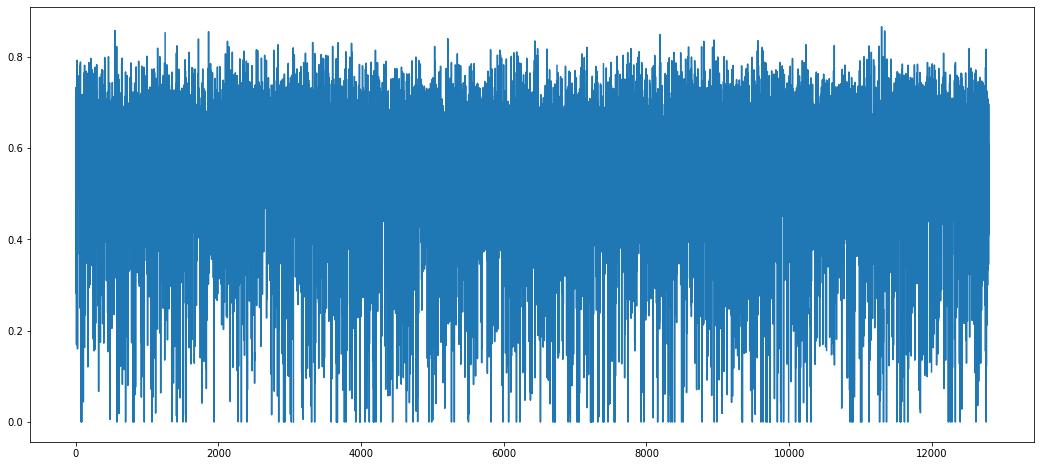

In [20]:
plt.figure(figsize=(18,8))
plt.plot(iou)